# Advanced Machine Learning Project

---



Autori: Cogo Luca (830045), Confalonieri Riccardo (830404) <br>
E-mail: l.cogo@campus.unimib.it, r.confalonieri5@campus.unimib.it

<h1> Histopatological Cancer Detection </h1>

Il crescente utilizzo negli ultimi anni di immagini digitali in campo medico ha reso possibile l'utilizzo di tecniche di apprendimento automatico per la diagnosi di varie patologie. Si vuole dunque valutare l'efficacia delle più recenti tecniche di deep learning nel diagnosticare tumori al sistema linfatico a partire da immagini realizzate tramite appositi scanner WSI (Whole Slide Image), rese disponibili dal dataset benchmark PatchCamelyon (PCam). A tale scopo verranno descritti diversi approcci: una Convolutional Neural Network addestrata da zero e alcune architetture (VGG16, DenseNet-121, MobileNetV2) basate su modelli pre-trainati per il riconoscimento di immagini (Imagenet). 

## Import packages

In [ ]:
# libreria per il tuning degli iperparametri
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [ ]:
# caricamento e salvataggio su drive
from google.colab import drive

# lettura file
import pandas as pd
import numpy as np

# per plot immagini
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Polygon
from PIL import Image
import random


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from skimage.io import imread

# per valutare i risultati
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import time # per valutare tempi di esecuzione

# copia ed esportazione file zip
import zipfile
import shutil
import os
# conteggio numero di esempi per classe
from collections import Counter

from tensorflow import keras
from tensorflow.keras import layers
# salvataggio modelli e early_stopping regularization
from keras.callbacks import EarlyStopping, ModelCheckpoint
# per costruire modelli
from tensorflow.keras.models import Model
# Funzioni di ottimizzazione
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall # metrica di recall per i modelli
import keras_tuner as kt # libreria per tuning iperparametri

# Modelli per fine-tuning
from tensorflow.keras.applications.vgg16 import VGG16 # modello vgg16
from tensorflow.keras.applications.densenet import DenseNet121 # modello densenet-121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # modello mobilenet_v2

In [ ]:
# caricamento drive
drive.mount('/content/drive', force_remount=True)

# path principale delle cartella
drive_path = '/content/drive/MyDrive/Colab Notebooks/AML/Cogo_Confalonieri_Progetto_AML/'

Mounted at /content/drive


## Data Loader
Dato che le immagini a disposizione sono tante in fase iniziale ci concentriamo solo su una piccola porzione, inoltre sappiamo che il problema è ristretto alla regione centrale di $32x32$ px. Inizio quindi a importare le immagini di training e validation e visualizzarle  evidenziandone la regione d'interesse per il problema. <br>

Per velocizzare il caricamento le immagini necessarie sono già state preventivamente <i>salvate in formato .zip e suddivise in sottocartelle</i>, ognuna contenente una specifica classe. In questo modo è possibile utilizzare i metodi di import di keras che velocizzano ed ottimizzano il caricamento di grandi quantità di immagini. Inoltre durante la fase di subsampling del dataset completo e creazione dello zip si è anche proceduto a <i>bilanciare il numero di immagini</i> per ciascuna classe così da avere dei dati effettivamente pronti per essere passati ad un modello neurale.

In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/train_small.zip', 'train_small.zip')
zip = zipfile.ZipFile('train_small.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('train_small.zip')

In [ ]:
def import_train_validation(img_size = (96,96), val_split = 0.15, batch_size = 64,
                            dataset_path = './train_small'):
  # definisco il generator delle immagini, in questo caso non effettuo alcuna operazione
  # di data augmentation. Le immagini sono solo riscalate nell'intervallo [0,1] con
  # valori float, inoltre preservo un 15% come validation set
  image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                 validation_split = val_split
                                                                 )

  # carico il training set
  train_set = image_generator.flow_from_directory(
      dataset_path, # path
      class_mode='categorical', # tipo di variabile da predire
      classes = ['0', '1'], # nome delle classi
      color_mode = 'rgb',
      shuffle = True,
      target_size = img_size, # dim. immagini
      batch_size = batch_size, 
      subset = 'training', # carica un subset di training (85%)
      seed = 830045
  )

  validation_set = image_generator.flow_from_directory(
      dataset_path,
      classes = ['0', '1'],
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, # false perchè nel validation non mi interessa l'ordine!
      target_size = img_size,
      batch_size = batch_size,
      subset = 'validation', # carica un subset di validation (15%)
      seed = 830045
  )

  return train_set, validation_set

In [ ]:
train_set, validation_set = import_train_validation()

Found 21326 images belonging to 2 classes.
Found 3762 images belonging to 2 classes.


In [ ]:
# Visualizzo alcune informazioni di base sulle immagini
print('Tipo delle immagini:', type(train_set))
print('Numero di esempi di training:', train_set.samples)
print("Dimensione dell'immagine: " + str(train_set.image_shape))
print("Range di valori dell'immagine ["+ str(train_set[0][0].min()) + "," 
      + str(train_set[0][0].max()) + "]")
print("Tipo dei valori dell'immagine: ", type(train_set[0][0][0][0][0][0]))

# conto le img per classe
counter = Counter(train_set.classes)
print('Numero di esempi per la classe 0:', list(counter.values())[0])
print('Numero di esempi per la classe 1:', list(counter.values())[1])

Tipo delle immagini: <class 'keras.preprocessing.image.DirectoryIterator'>
Numero di esempi di training: 21326
Dimensione dell'immagine: (96, 96, 3)
Range di valori dell'immagine [0.0,1.0]
Tipo dei valori dell'immagine:  <class 'numpy.float32'>
Numero di esempi per la classe 0: 10663
Numero di esempi per la classe 1: 10663


Il dataset caricato è di tipo proprietario di keras, inoltre possiamo notare che gli altri parametri di base corrispondono a quanto ci si aspettava rispetto ai parametri definiti per il caricamento. Inoltre possiamo notare che effettivamente le classi sono bilanciate e che nel training set si hanno a disposizione $10663$ immagini per ogni classe.

### Visual inspection 
Proviamo a visualizzare qualche immagine evidenziandone la regione d'interesse a seconda della label per capire meglio il task da affrontare.

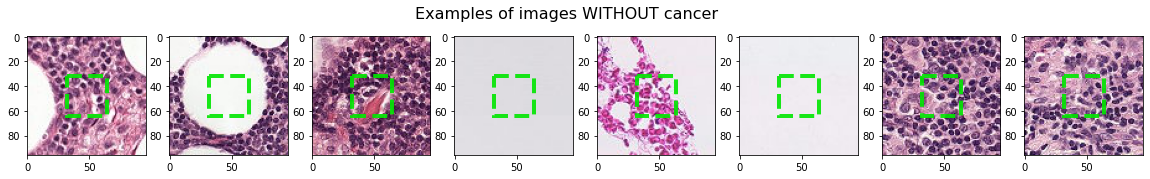

In [ ]:
# immagini senza evidenza di tumore (label = 0)

# plotto 8 figure in una sola riga
fig, ax = plt.subplots(1,8, figsize=(20,5))

# numero di immagini già visualizzate
plotted_img = 0
# lista con indici delle immagini già visualizzate
lst_plotted_img = []

# continuo finchè non ho plottato 8 immagini con label = 0
while plotted_img < 8:
  # prendo un img random dal primo batch
  idx = random.randint(0, 63)

  # se la label dell'immagine è = 0 e non l'avevo ancora estratta la visualizzo
  if (idx not in lst_plotted_img) and (np.argmax(train_set[0][1][idx]) == 0):
    ax[plotted_img].imshow(train_set[0][0][idx])
    # aggiungo un poligono intorno alla regione centrale d'interesse
    p = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
            fc=(0.0, 0.0, 0.0, 0.0), 
            ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
    ax[plotted_img].add_patch(p)

    # aggiorno il contatore contatore delle img visualizzate
    plotted_img = plotted_img + 1
    # aggiorno la lista con gli indici già visualizzati
    lst_plotted_img.append(idx)


fig.suptitle('Examples of images WITHOUT cancer', y=0.75, fontsize=16)
plt.show()

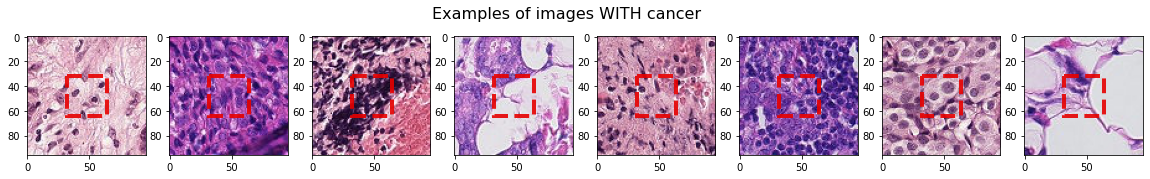

In [ ]:
# immagini con evidenza di tumore (label = 1)

# plotto 8 figure in una sola riga
fig, ax = plt.subplots(1,8, figsize=(20,5))

# numero di immagini già visualizzate
plotted_img = 0
# lista con indici delle immagini già visualizzate
lst_plotted_img = []

# continuo finchè non ho plottato 8 immagini con label = 1
while plotted_img < 8:
  # prendo un img random dal primo batch
  idx = random.randint(0, 63)

  # se la label dell'immagine è = 1 e non l'avevo ancora estratta la visualizzo
  if (idx not in lst_plotted_img) and (np.argmax(train_set[0][1][idx]) == 1):
    ax[plotted_img].imshow(train_set[0][0][idx])
    # aggiungo un poligono intorno alla regione centrale d'interesse
    p = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
            fc=(0.0, 0.0, 0.0, 0.0), 
            ec=(0.9, 0.0, 0.0 ,0.9), lw=4, linestyle='--')
    ax[plotted_img].add_patch(p)

    # aggiorno il contatore contatore delle img visualizzate
    plotted_img = plotted_img + 1
    # aggiorno la lista con gli indici già visualizzati
    lst_plotted_img.append(idx)


fig.suptitle('Examples of images WITH cancer', y=0.75, fontsize=16)
plt.show()

È possibile notare come nelle immagini che non contengono tumore siano presenti anche immagini apparentemente mal digitalizzate che risultano essere completamente bianche o nere. Mentre non sembra esserci un pattern visivo chiaro per distinguere la presenza o meno del tumore (almeno per i non esperti), questo fa capire come il task sia complesso e giustifica quindi un approccio con reti neurali.

### Test set
Carico anche una piccola porzione di test set per poter valutare i modelli che verranno man mano trainati.

In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/test_small.zip', 'test_small.zip')
zip = zipfile.ZipFile('test_small.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('test_small.zip')

# copio anche il csv che contiene le label di riferimento per il test set
shutil.copyfile(drive_path + 'Data/dataset_labels/test_small_label.csv', 'test_small_label.csv')

'test_small_label.csv'

In [ ]:
def import_test(img_size = (96,96), batch_size = 64, dataset_path = './test_small'):
  # definisco lo stesso generator utilizzato in precedenza, con la differenza
  # che in questo caso non è necessario fissare lo split per il validation
  image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

  # carico il test set
  test_set = image_generator.flow_from_directory(
      dataset_path,
      classes = ['-1'], # è stata creata una classe fittizia per poter utilizzare flow_from_directory
      class_mode='categorical',
      color_mode = 'rgb',
      shuffle = False, # false perchè nel validation non mi interessa l'ordine!
      target_size = img_size,
      batch_size = batch_size
  )

  # carico il csv che contiene le label
  df_test = pd.read_csv(dataset_path + '_label.csv')
  df_test = df_test.sort_values(by=['id'])

  # ritorno il test set e un dataframe le label corrispondenti
  return test_set, df_test

## Funzioni utili
Si definiscono alcune funzioni utili, comuni a tutti i modelli che verranno implementati. In questo modo è possibile visualizzare l'andamento del training con il confronto di loss e accuracy sul training e validation set ed anche effettuare le predizioni su un test set visualizzando i risultati in maniera grafica.

In [ ]:
# visualizza a video alcune informazioni testuali di base sul training del modello
# e due grafici per analizzare l'andamento della loss e dell'accuracy durante il training
def resume_model_history(history, early_stop = None):
  # estraggo il numero di epoche nel caso in cui l'early stopping è stato utilizzato
  if early_stop is not None:
    # verifico se l'early stop è entrato in funzione, se si prendo l'epoca in cui
    # si è fermato il training, altrimenti l'epoca migliore (corrisponderà al tot. max delle epoche)
    tot_epoch = early_stop.stopped_epoch+1 if (early_stop.stopped_epoch != 0) else early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  # senza early_stopping l'ultima epoca e la migliore coincidono
  else:
    tot_epoch = len(history.epoch)
    best_epoch = tot_epoch

  # visualizzo i risultati in forma testuale
  print("Numero di epoche totali:", tot_epoch)
  print("Epoca migliore (weights restored):", best_epoch)
  print("Accuracy training set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print("Accuracy validation set all'epoca " + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print("Loss training set all'epoca " + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  print("Loss validation set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][best_epoch -1]))
  
  print('\n\n')

  # visualizzo i grafici di loss e accuracy per training e validation
  fig = plt.figure(figsize =(20, 6))

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'])

  # stesso procedimento per l'accuracy
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'], loc='lower right')

In [ ]:
# Function that allows you to compute and graphically view some
# accuracy metrics on predictions
def evaluate_prediction(model, x_test, y_test):

  # prediction for test set
  y_hat = model.predict(x_test)
  # get the label correspoinding to the top score
  y_hat = y_hat.argmax(axis=1)

  # get the confusion matrix
  cm = confusion_matrix(y_test, y_hat)

  # get the roc curve and auc
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_hat)
  auc_keras = auc(fpr_keras, tpr_keras)


  # get and visualize the classification report
  cl = classification_report(y_test, y_hat) 
  print('\nClassification Report\n', cl)

  # plot beautiful confusion matrix
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu");  

  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix'); 


  # Plot ROC

  plt.figure()
  plt.plot(fpr_keras,tpr_keras)

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.text(x=0.4, y=0.4 , s = f'AUC: {round(auc_keras,3)}', bbox = dict(boxstyle= 'square', color = 'lightblue'), fontsize = 16)
  plt.show()


  return y_hat, cl

## Fine tuning
In questa sezione verrà provato un approccio diverso, invece di creare un modello from scrach specifico per questo task si proverà ad utilizzare dei modelli predefiniti su cui effettuare un <i>fine tuning</i>. In particolare verranno effettuate diverse prove con modelli, tra i diversi modelli possibili si è cercato di utilizzare modelli che richiedessero lo stesso input size $(224,244,3)$ e con diverso numero di parametri e operazioni richieste per studiarne le diversità.

In [ ]:
# reimporto i dati con la dimensione opportuna
train_set, validation_set = import_train_validation(img_size = (224, 224))

print("Dimensione dell'immagine: " + str(train_set.image_shape) + '\n\n')

# carico il test set unico per tutti i modelli per poterli valutare coerentemente
test_set, label_test = import_test(img_size = (224, 224))

print("Dimensione dell'immagine di test: " + str(test_set.image_shape))

Found 21326 images belonging to 2 classes.
Found 3762 images belonging to 2 classes.
Dimensione dell'immagine: (224, 224, 3)


Found 5000 images belonging to 1 classes.
Dimensione dell'immagine di test: (224, 224, 3)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.001, 
                           verbose=1, restore_best_weights=True) 

### VGG16
Il primo modello che andiamo ad analizzare è VGG16. Questo modello è caratterizzata dall'applicazione di una serie di blocchi convoluzionali con dimensioni del kernel piccole, seguiti poi da due diversi layer fully connected che mappano a $4096$ e un ultimo layer finale che mappa a $1000$, la dimensione del problema di classificazione originale. Questi ultimi layer in particolare richiedono un numero molto alto di parametri e anche rispetto al numero di operazioni richieste questa rete risulta essere molto complessa rispetto ad altre possibile scelte che verranno analizzate successivamente.

<figure>
<center>
<img src='https://miro.medium.com/max/9999/1*ZqkQYVB3_Gw0hjrAMzi6_A.png' />
<figcaption>VGG16 architecture</figcaption></center>
</figure>


<br> Come si può notare dall'immagine la prima operazione richiesta per utilizzare questa architettura e utilizzare delle immagini con dimensione $224x244$ dato che le nostre immagini di default sono più piccole modifico il caricamento per far si che matchi con queste specifiche.


In [ ]:
# Carico il modello di base VGG16
base_vgg16_model = VGG16(weights='imagenet')

# taglio gli ultimi layer fully connected dal modello
vgg16_model = Model(inputs=base_vgg16_model.input, 
                    outputs=base_vgg16_model.get_layer('flatten').output)
# visualizzo il nuovo summary
vgg16_model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Una volta estratti i layer funzionali al nostro task definisco un nuovo modello che aggiunge dei nuovi layer utili per la classificazione. I layer estratti dal modello vgg16 verranno ''bloccati'' durante il training della nuova rete in modo da non modificare i pesi precedentemente allenati.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in vgg16_model.layers:
  layer.trainable = False


# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=train_set.image_shape) # layer di input
x = inputs

# applico lo stesso preprocessing applicato all'input di vgg16
x = keras.applications.vgg16.preprocess_input(x)
# applico la rete VGG16 precedentemente estratta
x = vgg16_model(x)

# LAYER AGGIUNTIVI

# fully connected che mappa a 64
x = keras.layers.Dense(64, activation = "relu")(x)
#x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(16, activation = "relu")(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(2, activation = "sigmoid")(x)

outputs = x

In [ ]:
# definisco il macro modello
model_vgg = keras.Model(inputs=inputs, outputs=outputs)

# compilo il modello
model_vgg.compile(optimizer=Adam(0.001), loss="binary_crossentropy",  
                  metrics=["accuracy", Recall(name = 'recall')])

Si può verificare che il modello VGG così creato contiene $16.323.026$ di cui $1.608.338$ trainabili. Il modello risulta quindi essere molto grande, questo ci aspettiamo che risulti in un maggiore tempo necessario per il training.

In [ ]:
model_vgg.summary() # visualizzo il summary finale del modello

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 model (Functional)          (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                           

Effettuiamo il training del modello con un numero massimo di $50$ epoche, inoltre con la tecnica dell'EarlyStopping il modello verrà interrotto qualora per tre epoche consecutive non vi fossero miglioramenti nella validation loss. Nel caso in cui il training fosse interrotto verranno anche ripristinati i pesi migliori individuati precedentemente, cosi da poter ottenere il miglior risultato.

In [ ]:
# early stopping per fermare il modello in caso in cui la loss del validation non migliori per
# 3 iterazioni consecutive. Viene anche ripristinata la migliore epoca fino a quel punto
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta = 0, 
                           verbose=1, restore_best_weights=True) 


model_vgg_history = model_vgg.fit(train_set, epochs = 50, shuffle = True, 
                                  validation_data = validation_set,
                                  verbose = 1, callbacks = [early_stop])

Epoch 1/50
334/334 [==============================] - 127s 346ms/step - loss: 0.6582 - accuracy: 0.6027 - recall: 0.5877 - val_loss: 0.5955 - val_accuracy: 0.6837 - val_recall: 0.6707
Epoch 2/50
334/334 [==============================] - 103s 308ms/step - loss: 0.6114 - accuracy: 0.6747 - recall: 0.6682 - val_loss: 0.5715 - val_accuracy: 0.7081 - val_recall: 0.6847
Epoch 3/50
334/334 [==============================] - 103s 309ms/step - loss: 0.5895 - accuracy: 0.6933 - recall: 0.6851 - val_loss: 0.5624 - val_accuracy: 0.7148 - val_recall: 0.7055
Epoch 4/50
334/334 [==============================] - 103s 308ms/step - loss: 0.5811 - accuracy: 0.7002 - recall: 0.6931 - val_loss: 0.5701 - val_accuracy: 0.7036 - val_recall: 0.6970
Epoch 5/50
334/334 [==============================] - 103s 309ms/step - loss: 0.5771 - accuracy: 0.7015 - recall: 0.6939 - val_loss: 0.5575 - val_accuracy: 0.7265 - val_recall: 0.7103
Epoch 6/50
334/334 [==============================] - 103s 309ms/step - loss: 0.

Si visualizza quindi il grafico di training, le epoche rimosse per via dell'early stopping sono mostrate con linee tratteggiate.

Numero di epoche totali: 10
Epoca migliore (weights restored): 7
Accuracy training set all'epoca 7: 0.7082434296607971
Accuracy validation set all'epoca 7: 0.7336522936820984
Loss training set all'epoca 7: 0.565551221370697
Loss validation set all'epoca 7: 0.5400751233100891





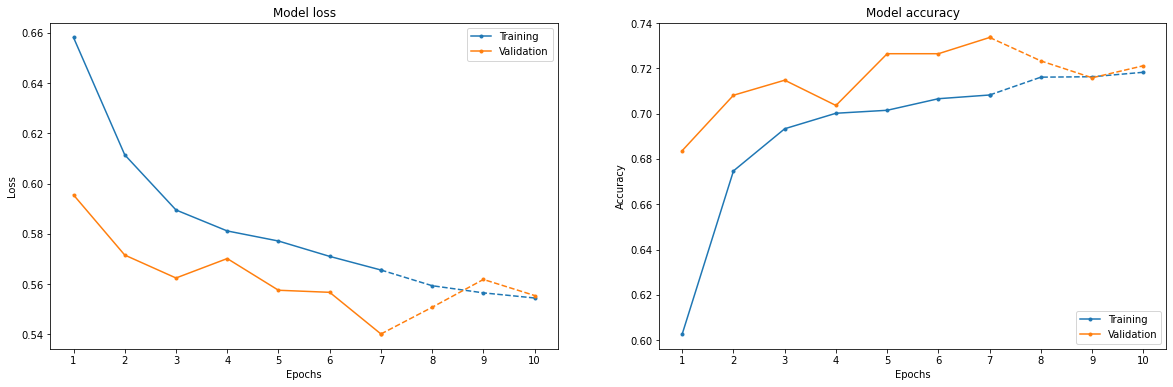

In [ ]:
resume_model_history(model_vgg_history, early_stop)

Come si può notare dal grafico, e dai valori riportati, il modello ottiene una buona accuracy ma non particolarmente elevata. Inoltre sembra essere soggetto ad underfitting, il quale è presente anche aumentando il numero di layer FC finali o cercando di cambiare leggermente l'architettura.

In [ ]:
# salvataggio del modello
model_vgg.save(drive_path + 'Keras_Model/vgg16.h5')

Valutiamo dunque il modello sul test set small, ci attendiamo che i risultati siano comparabili con quanto visto nel validation set.


Classification Report
               precision    recall  f1-score   support

           0       0.77      0.66      0.71      2500
           1       0.70      0.80      0.75      2500

    accuracy                           0.73      5000
   macro avg       0.74      0.73      0.73      5000
weighted avg       0.74      0.73      0.73      5000



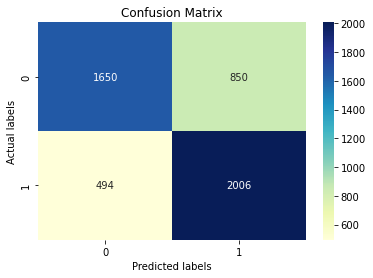

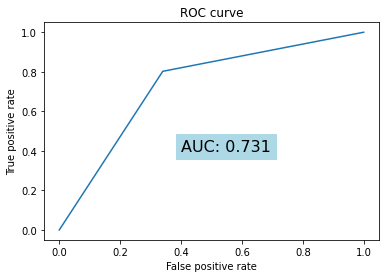

In [ ]:
#model_vgg = keras.models.load_model(drive_path + 'Keras_Model/vgg16.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_vgg, test_set, label_test['label'].values)

Come previsto i risultati sono in linea con quelli del validation, tuttavia il modello prevede in modo errato diverse casistiche di presenza del tumore non risultando dunque ideale per il task. Proviamo inoltre a valutare il modello rispetto al tempo richiesto per predire una sola immagine, per farlo si effettua la predizione su un batch di $64$ immagini e si media il tempo totale. Ovviamente la tempistica è inficiata dalla potenza di calcolo e dal numero di GPU a disposizione (exe parallela).

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = model_vgg.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.194 secondi necessari per predire una singola immagine! ---


### DenseNet-121
Il secondo modello che prendiamo in considerazione è DenseNet-121. A differenza del precedente questo modello è caratterizzato da un numero molto inferiore di parametri ed anche di operazioni richieste, nonostante questo riesce a fornire una predizione top-$1$ più accurata. <br>
L'architettura DenseNet è molto più complessa della precedente, utilizza dei blocchi detti ``Dense block`` e dei ``transition Block`` per evitare il problema del vanishing gradient che si verifica con architetture molto profonde, infine utilizza soltanto un layer fully-connected. 

<figure>
<center>
<img src='https://miro.medium.com/max/700/1*vIZhPImFr9Gjpx6ZB7IOJg.png' />
<figcaption>DenseNet-121 architecture</figcaption></center>
</figure>


<br> Come si può notare dall'immagine il volume rimane costante nei ``Dense block``, D in figura, mentre si dimezza ogni volta che viene applicato un ``transition Block``, T in figura. Per superare il problema del vanishing gradient i diversi blocchi convoluzionali e i diversi ``Dense block`` non sono solo collegati in sequenza ma anche con collegamenti diretti tra loro. Questo incoraggia il modello a utilizzare le features già create e permette di ridurre effettivamente il numero di parametri.


In [ ]:
# Carico il modello di base densenet-121
base_dn121_model = DenseNet121(weights='imagenet')

# taglio gli ultimi layer fully connected dal modello
dn121_model = Model(inputs=base_dn121_model.input, 
                    outputs=base_dn121_model.get_layer('avg_pool').output)
# visualizzo il nuovo summary
# dn121_model.summary()

33202176/33188688 [==============================] - 0s 0us/step


Una volta estratti i layer funzionali al nostro task definisco un nuovo modello che aggiunge dei nuovi layer utili per la classificazione. I layer estratti dal modello DenseNet-121 verranno ''bloccati'' durante il training della nuova rete in modo da non modificare i pesi precedentemente allenati.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in dn121_model.layers:
  layer.trainable = False


# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=train_set.image_shape) # layer di input
x = inputs

# applico lo stesso preprocessing applicato all'input di densenet
x = keras.applications.densenet.preprocess_input(x)
# applico la rete densenet-121 precedentemente estratta
x = dn121_model(x)

# LAYER AGGIUNTIVI

initializer = keras.initializers.GlorotUniform(seed=1234)

# fully connected che mappa a 64
x = keras.layers.Dense(64, activation = "relu", kernel_initializer=initializer)(x)
#x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, activation = "relu", kernel_initializer=initializer)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation = "relu", kernel_initializer=initializer)(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(2, activation = "sigmoid")(x)

outputs = x

In [ ]:
# definisco il macro modello
model_dn = keras.Model(inputs=inputs, outputs=outputs)

model_dn.compile(optimizer=keras.optimizers.Adam(0.001), 
                 loss="binary_crossentropy", 
                 metrics=["accuracy", Recall(name = 'recall')])

Si può verificare che il modello così creato contiene $7.105.466$ di cui $67.962$ trainabili. Il modello richiede quindi molti meno parametri rispetto a VGG!

In [ ]:
model_dn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 model_2 (Functional)        (None, 1024)              7037504   
                                                           

Effettuiamo il training utilizzando i medesimi parametri precedenti, $50$ epoche massime e stesso early stopping.

In [ ]:
model_dn_history = model_dn.fit(train_set, epochs = 50, shuffle = True,
                                validation_data = validation_set,
                                verbose = 1, callbacks = [early_stop])

Epoch 1/50
334/334 [==============================] - 86s 234ms/step - loss: 0.5806 - accuracy: 0.7031 - recall: 0.6862 - val_loss: 0.5111 - val_accuracy: 0.7552 - val_recall: 0.7562
Epoch 2/50
334/334 [==============================] - 73s 218ms/step - loss: 0.5383 - accuracy: 0.7391 - recall: 0.7456 - val_loss: 0.4993 - val_accuracy: 0.7640 - val_recall: 0.7698
Epoch 3/50
334/334 [==============================] - 73s 218ms/step - loss: 0.5307 - accuracy: 0.7427 - recall: 0.7494 - val_loss: 0.4938 - val_accuracy: 0.7634 - val_recall: 0.7682
Epoch 4/50
334/334 [==============================] - 73s 218ms/step - loss: 0.5230 - accuracy: 0.7469 - recall: 0.7519 - val_loss: 0.4924 - val_accuracy: 0.7706 - val_recall: 0.7727
Epoch 5/50
334/334 [==============================] - 73s 218ms/step - loss: 0.5156 - accuracy: 0.7503 - recall: 0.7541 - val_loss: 0.4833 - val_accuracy: 0.7727 - val_recall: 0.7764
Epoch 6/50
334/334 [==============================] - 73s 217ms/step - loss: 0.5142 -

Dai risultati sul validation il modello sembra performare meglio di VGG come accuratezza e loss. 

Numero di epoche totali: 22
Epoca migliore (weights restored): 19
Accuracy training set all'epoca 19: 0.778439462184906
Accuracy validation set all'epoca 19: 0.7969165444374084
Loss training set all'epoca 19: 0.47297897934913635
Loss validation set all'epoca 19: 0.44908034801483154





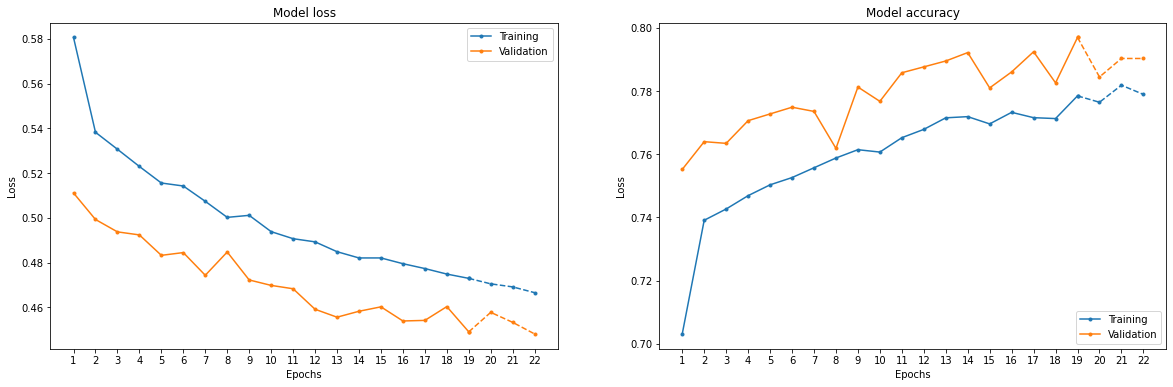

In [ ]:
resume_model_history(model_dn_history, early_stop)

Anche in questo caso il modello sembra essere in leggero underfitting

In [ ]:
# salvataggio del modello
model_dn.save(drive_path + 'Keras_Model/densenet.h5')

Verificando i risultati sul test set small è possibile verificare come lo score sia nuovamente uguale a quello del validation, come atteso. Inoltre si nota un forte miglioramento rispetto a VGG in tutte le metriche. Soprattutto migliora di molto la recall della classe $1$, ovvero quella contenente immagini di tumori. 


Classification Report
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      2500
           1       0.77      0.81      0.79      2500

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



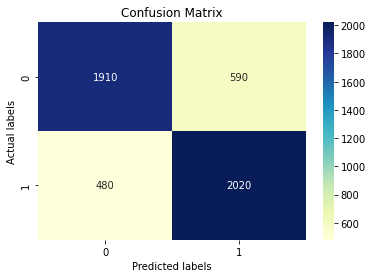

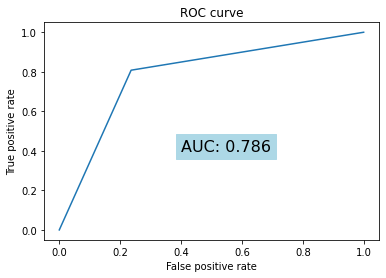

In [ ]:
# model_dn = keras.models.load_model(drive_path + 'Keras_Model/densenet.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_dn, test_set, label_test['label'].values)

Valutando il modello come tempistiche nella predizione si nota tuttavia un inatteso aumento, seppur leggero, delle tempistiche. 

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = model_dn.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.223 secondi necessari per predire una singola immagine! ---


### MobileNetV2
Il terzo, e ultimo, modello che consideriamo per il fine tuning è MobileNetV2. Questo modello ha un numero di parametri inferiore ai due precedenti e richiede un numero minimo di operazioni, quindi anche il peso del modello è molto leggero: solo $14$MB. Nonostante questo sul task originale riesce a raggiungere gli stessi livelli di accuratezza di VGG16! Questo modello è stato infatti sviluppato da Google per essere utilizzato su dispositivi mobili. <br>
L'architettura di MobileNetV2 si basa su dei blocchi detti:

* ``inverted residual``. Che utilizza un blocco residuale invertito che attraverso una prima convoluzione per allargare l'immagine, una seconda convoluzione in profondità e infine una convoluzione $1x1$ per ridurre il numero di canali (al contrario la i blocchi residuali classici prima comprimono l'immagine e poi la riallargano). 
<figure>
<center>
<img src='https://user-images.githubusercontent.com/18547241/53912465-997fd900-401e-11e9-82b0-c0be0f2abf93.png' height = 100/></center>
</figure>


* ``linear bottleneck layer``. Permettono di non distruggere troppe informazioni con attivazioni non lineari.

L'architettura completa è quindi composta dai seguenti layers:
<figure>
<center>
<img src='https://miro.medium.com/max/1016/1*5iA55983nBMlQn9f6ICxKg.png' height = 300/>
<figcaption>MobileNetV2 architecture</figcaption></center>
</figure>

Dove $t$ è il fattore di espansione, $c$ il numero di canali in output, $n$ il numero di ripetizioni, $s$ lo stride. Per le convoluzioni spaziali è utilizzato un kernel $3x3$.


Si è scelto di provare a utilizzare questo modello in quanto, se efficace, potrebbe rendere possibile il riconoscimento del cancro in real-time sfruttando le immagini che arrivano durante analisi come le [colonscopie](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-01314-8). In tal senso si è mossa da tempo anche l'Unione Europea con il progetto [MagentiqEye](https://www.magentiq.com/).

In [ ]:
# Carico il modello di base MobileNetV2
base_mn_model = MobileNetV2(weights='imagenet')

# taglio gli ultimi layer fully connected dal modello
mn_model = Model(inputs=base_mn_model.input, 
                 outputs=base_mn_model.get_layer(base_mn_model.layers[len(base_mn_model.layers)-2].name).output)
# visualizzo il nuovo summary
# mn_model.summary()

14548992/14536120 [==============================] - 0s 0us/step


Una volta estratti i layer funzionali al nostro task definisco un nuovo modello che aggiunge dei nuovi layer utili per la classificazione. I layer estratti dal modello MobileNetV2 verranno ''bloccati'' durante il training della nuova rete in modo da non modificare i pesi precedentemente allenati.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in mn_model.layers:
  layer.trainable = False


# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=train_set.image_shape) # layer di input
x = inputs

# applico lo stesso preprocessing applicato all'input di densenet
x = keras.applications.mobilenet_v2.preprocess_input(x)
# applico la rete mobilenet precedentemente estratta
x = mn_model(x)

# LAYER AGGIUNTIVI

# fully connected che mappa a 64
x = keras.layers.Dense(64, activation = "relu")(x)
#x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(16, activation = "relu")(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(2, activation = "sigmoid")(x)

outputs = x

In [ ]:
# definisco il macro modello
model_mn = keras.Model(inputs=inputs, outputs=outputs)

model_mn.compile(optimizer=keras.optimizers.Adam(0.001), 
                 loss="binary_crossentropy", 
                 metrics = ["accuracy", Recall(name = 'recall')])

Si può verificare che il modello così creato contiene $2.342.610$ di cui $84.626$ trainabili. Il modello risulta quindi essere il più piccolo rispetto al numero di parametri totale, anche se contiene qualche parametro in più da trainare rispetto a denseNet.

In [ ]:
model_mn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_4 (Functional)        (None, 1280)              2257984   
                                                                 
 dense_8 (Dense)             (None, 64)                81984     
                                                                 
 dense_9 (Dense)             (None, 32)                2080

Effettuiamo il training utilizzando i medesimi parametri precedenti, $50$ epoche massime e stesso early stopping.

In [ ]:
model_mn_history = model_mn.fit(train_set, epochs = 50, shuffle = True, 
                                validation_data = validation_set,
                                verbose = 1, callbacks = [early_stop])

Epoch 1/50
334/334 [==============================] - 50s 117ms/step - loss: 0.6745 - accuracy: 0.5733 - recall: 0.5644 - val_loss: 0.6026 - val_accuracy: 0.6837 - val_recall: 0.6651
Epoch 2/50
334/334 [==============================] - 37s 111ms/step - loss: 0.5871 - accuracy: 0.7005 - recall: 0.6986 - val_loss: 0.5454 - val_accuracy: 0.7403 - val_recall: 0.7419
Epoch 3/50
334/334 [==============================] - 36s 108ms/step - loss: 0.5641 - accuracy: 0.7232 - recall: 0.7232 - val_loss: 0.5274 - val_accuracy: 0.7440 - val_recall: 0.7400
Epoch 4/50
334/334 [==============================] - 36s 108ms/step - loss: 0.5579 - accuracy: 0.7195 - recall: 0.7210 - val_loss: 0.5238 - val_accuracy: 0.7477 - val_recall: 0.7461
Epoch 5/50
334/334 [==============================] - 36s 107ms/step - loss: 0.5524 - accuracy: 0.7225 - recall: 0.7244 - val_loss: 0.5380 - val_accuracy: 0.7398 - val_recall: 0.7408
Epoch 6/50
334/334 [==============================] - 36s 107ms/step - loss: 0.5485 -

Numero di epoche totali: 10
Epoca migliore (weights restored): 7
Accuracy training set all'epoca 7: 0.7272812724113464
Accuracy validation set all'epoca 7: 0.7533227205276489
Loss training set all'epoca 7: 0.5459520220756531
Loss validation set all'epoca 7: 0.5107198357582092





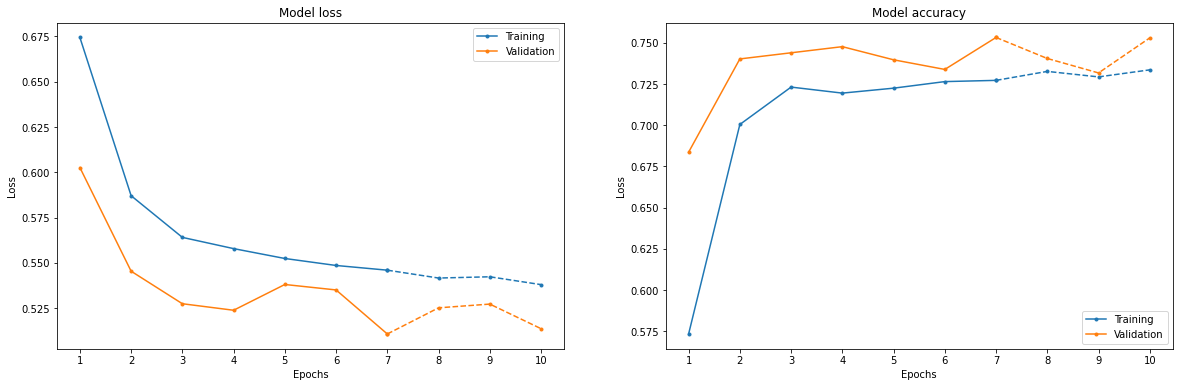

In [ ]:
resume_model_history(model_mn_history, early_stop)

I risultati del modello sono in linea con il modello VGG, con il quale è solitamente comparato. L'ideazione di MobileNet-V2 si deve infatti all'idea di diminuire i parametri del modello mantenendo comunque le performance simili a VGG. 

In [ ]:
# salvataggio del modello -> l'implementazione di mobilenet di keras è particolare
# e quindi viene restituito un avviso. Questo modello è utile per il TEST, non vogliamo
# far ripartire il training e quindi va bene comunque
model_mn.save(drive_path + 'Keras_Model/mobnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Anche in questo caso il test set small ottiene risultati in linea con quelli osservati sul validation.


Classification Report
               precision    recall  f1-score   support

           0       0.75      0.72      0.73      2500
           1       0.73      0.76      0.74      2500

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



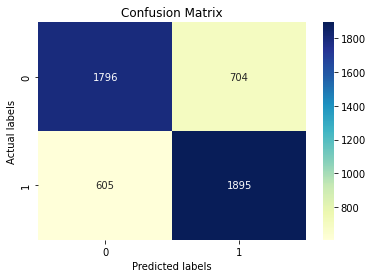

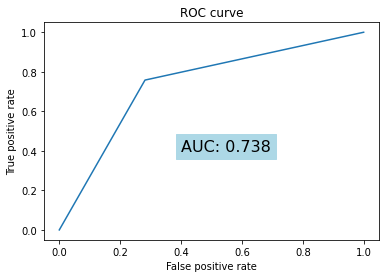

In [ ]:
# model_mn = keras.models.load_model(drive_path + 'Keras_Model/mobnet.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_mn, test_set, label_test['label'].values)

Analizzando le tempistiche del modello, come ci aspettavamo vista la sua leggerezza, si ottengono performance molto buone con predizioni quasi immediate. 

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = model_mn.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.156 secondi necessari per predire una singola immagine! ---


## Ensemble

Si prova a sviluppare la tecnica di average ensemble utilizzando i tre modelli sviluppati. Si uniscono quindi i modelli addestrati in un unica architettura mediando i risultati ottenuti. L'indipendenza dei tre modelli la si deve al fatto di avere tre architetture di base differenti, inoltre sono stati inizializzati diversamente i pesi dei layer.



In [ ]:
# code idea: https://stackoverflow.com/questions/67647843/is-there-a-way-to-ensemble-two-keras-h5-models-trained-for-same-classes


# Carico i modelli già trainati
model_mn = keras.models.load_model(drive_path + 'Keras_Model/mobnet.h5', compile=False)
model_mn._name = 'model1'
model_dn = keras.models.load_model(drive_path + 'Keras_Model/densenet.h5', compile=False)
model_dn._name = 'model2'
model_vgg = keras.models.load_model(drive_path + 'Keras_Model/vgg16.h5', compile=False)
model_vgg._name = 'model3'

# definisco la lista con i 3 modelli
models = [model_mn, model_dn, model_vgg]
# setto il layer di input
model_input = keras.Input(shape=train_set.image_shape)
# utilizzo i tre modelli per effettuate le predizioni e medio i valori del risultato
model_outputs = [model(model_input) for model in models]
ensemble_output = keras.layers.Average()(model_outputs)
ensemble_model = keras.Model(inputs=model_input, outputs=ensemble_output)  

# salvo l'ensemble
ensemble_model.save(drive_path + 'Keras_Model/ensemble.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# calcolo le predizioni sul validation per tutti i modelli
y_pred_ens = ensemble_model.predict(validation_set)
y_pred_vgg = model_vgg.predict(validation_set)
y_pred_dn = model_dn.predict(validation_set)
y_pred_mb = model_mn.predict(validation_set)

Valutiamo quindi i risultati dell'ensemble confrontandoli coi singoli risultati ottenuti dai tre modelli base. 

In [ ]:
# verifico lo score dell'ensemble rispetto al validation
print('Accuracy ensemble:', accuracy_score(np.argmax(y_pred_ens, axis = -1), validation_set.labels))
print('Accuracy VGG16:', accuracy_score(np.argmax(y_pred_vgg, axis = -1), validation_set.labels))
print('Accuracy DenseNet-121:', accuracy_score(np.argmax(y_pred_dn, axis = -1), validation_set.labels))
print('Accuracy MobileNet-V2:', accuracy_score(np.argmax(y_pred_mb, axis = -1), validation_set.labels))

Accuracy ensemble: 0.7700691121743753
Accuracy VGG16: 0.733652312599681
Accuracy DenseNet-121: 0.796916533758639
Accuracy MobileNet-V2: 0.7533227006911217


L'ensemble in media è migliore sia di MobileNet che VGG, tuttavia non riesce a raggiungere le performance di DenseNet. Si potrebbe tuttavia provare ad utilizzare tecniche di ensemble più complesse.


Classification Report
               precision    recall  f1-score   support

           0       0.79      0.72      0.76      2500
           1       0.75      0.81      0.77      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



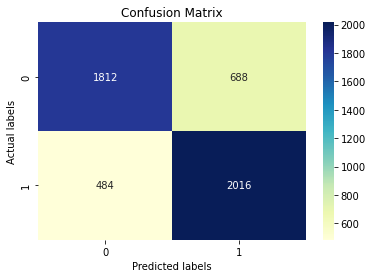

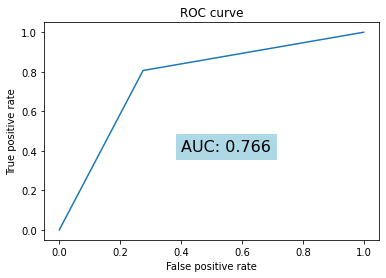

In [ ]:
# ensemble_model = keras.models.load_model(drive_path + 'Keras_Model/ensemble.h5', compile=False)
# valuto l'ensemble sul test set
_, _ = evaluate_prediction(ensemble_model, test_set, label_test['label'].values)

I risultati sul test set small confermano quanto visto sul validation set, il modello DenseNet è sicuramente il migliore rispetto alle altre possibilità. Inoltre l'ensemble, per via del fatto di utilizzare tutti e tre i modelli, richiede tempi di predizione notevolmente più alti rispetto ai singoli modelli. 

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = ensemble_model.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.311 secondi necessari per predire una singola immagine! ---


## Hyperparameters tuning
Gli iperparametri utilizzati finora sono stati selezionati manualmente dopo una serie di prove. Si tenta quindi un approccio di tuning per selezionare i parametri migliori al fine di migliorare le performance dei modelli, per farlo si utilizza la libreria keras-tuner che permette una facile implementazione del tuning.

Inoltre in questa fase verranno introdotti tre nuovi layer di data augmentation, in ogni modello. Questi layer saranno anch'essi soggetti all'ottimizzazione. Questa scelta è dovuta al fatto che potrebbero aumentare le performance dei modelli e la loro robostuzza rispetto a possibili outlier come le immagini completamente bianche/nere evidenziate nella prima analisi. Le tecniche di augmentation considerate sono: random_flip, random_rotation, random_contrast. Un altro motivo per cui queste tecniche potrebbero essere utili è la diversità di macchinari per estrarre le immagini, ognuno dei quali potrebbe produrre immagini lievemente diverse.

### MobileNetV2 tuning
Effettuiamo il tuning su mobileNet, i parametri scelti per il tuning oltre ai layer di aumentation sono il numero di neuroni nei fully-connected finali, il valore di dropout e il learning_rate.



Definiamo la funzione che permette di costruire il modello con i parametri da tunare. Questa funzione è richiesta espressamente dalla libreria Keras-Tuner.

In [ ]:
def mobnet_model_builder(hp):
  # definisco la sequenza di operazioni del macro modello
  inputs = keras.Input(shape=train_set.image_shape) # layer di input
  x = inputs

  hp_flip = hp.Boolean('random_flip', default=False)
  if hp_flip:
    # flip dell'immagine
    x = keras.layers.RandomFlip(mode = "horizontal_and_vertical")(x)

  # rotazione dell'immagine
  hp_rotation = hp.Float('random_rotation', min_value=0.0, max_value=0.5, step=0.05)
  x = keras.layers.RandomRotation(factor =  hp_rotation)(x)

  # contrasto randomico
  hp_contrast = hp.Float('random_constrast', min_value=0.0, max_value=0.7, step=0.1)
  if hp_contrast != 0:
    x = keras.layers.RandomContrast(factor = hp_contrast)(x)

  # applico lo stesso preprocessing applicato all'input di densenet
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  # applico la rete mobileNet-V2 precedentemente estratta
  x = mn_model(x)

  # Tune del numero di neuroni per i layer densi
  hp_dense = hp.Int('dense_0', min_value=32, max_value=128, step=32)
  x = keras.layers.Dense(hp_dense, activation = "relu")(x)
  hp_drop = hp.Choice('dropout_0', values=[0.0, 0.2, 0.4, 0.5])
  x = keras.layers.Dropout(hp_drop)(x)
  hp_dense1 = hp.Int('dense_1', min_value=16, max_value=32, step=16)
  x = keras.layers.Dense(hp_dense1, activation = "relu")(x)
  hp_drop1 = hp.Choice('dropout_1', values=[0.0, 0.2, 0.4, 0.5])
  x = keras.layers.Dropout(hp_drop1)(x)
  hp_dense2 = hp.Int('dense_2', min_value=8, max_value=16, step=8)
  x = keras.layers.Dense(hp_dense2, activation = "relu")(x)
  # layer che mappa al numero di classi del nostro problema
  x = keras.layers.Dense(2, activation = "sigmoid")(x)

  outputs = x

  # definisco il macro modello
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Tune learning rate per l'ottimizzatore
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss="binary_crossentropy", 
                metrics = ["accuracy", Recall(name = 'recall')])

  return model

Dato che le combinazioni per il tuning sono molte si utilizza l'ottimizzatore bayesiano che permette di non testare tutte le possibili casistiche. Ogni nuova combinazione di iperparametri è infatti definita a partire dalle iterazioni precedenti basandosi sulle probabilità

In [ ]:
tuner = kt.BayesianOptimization(mobnet_model_builder,
                                objective='val_accuracy',
                                directory=drive_path+'keras_tuner',
                                max_trials = 100, overwrite=False,
                                project_name='mobile_net_opt')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/mobile_net_opt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/mobile_net_opt/tuner0.json


Faccio partire il tuner sul modello con un numero massimo di $25$ epoche, verrà inoltre utilizzata la stessa tecnica di earlyStopping descritta in precedenza.

In [ ]:
tuner.search(train_set, epochs=25, validation_data = validation_set, 
             shuffle = True, callbacks=[early_stop])

La nuova architettura è molto diversa dalla precedente individuata a mano con dei semplici test, si riportano di seguito il valore dei parametri individuati dal tuner. E' possibile notare come i layer di augmentation non siano stati utilizzati ad eccezione del random_contrast che però ha un fattore molto basso pari a $0.2$.

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print('------ Migliori parametri MobileNet-V2: ------')
best_hps.values

------ Migliori parametri MobileNet-V2: ------


{'dense_0': 128,
 'dense_1': 32,
 'dense_2': 8,
 'dropout_0': 0.2,
 'dropout_1': 0.5,
 'learning_rate': 0.0001,
 'random_constrast': 0.2,
 'random_flip': False,
 'random_rotation': 0.0}

Il tuner restituisce un modello già allenato sui parametri migliori, tuttavia è bene rieseguire il training da zero costruendo un nuovo modello. Nel farlo aumentiamo il numero di epoche tornando alla configurazione iniziale di $50$.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_mn_tune = tuner.hypermodel.build(best_hps)
history_mn_tune = model_mn_tune.fit(train_set, epochs=50, shuffle = True,
                                    validation_data = validation_set, 
                                    callbacks=[early_stop])

Epoch 1/50
334/334 [==============================] - 54s 125ms/step - loss: 0.6975 - accuracy: 0.5034 - recall: 0.5860 - val_loss: 0.6932 - val_accuracy: 0.5465 - val_recall: 0.5133
Epoch 2/50
334/334 [==============================] - 40s 119ms/step - loss: 0.6926 - accuracy: 0.5148 - recall: 0.5865 - val_loss: 0.6853 - val_accuracy: 0.6664 - val_recall: 0.4333
Epoch 3/50
334/334 [==============================] - 39s 116ms/step - loss: 0.6829 - accuracy: 0.5720 - recall: 0.6850 - val_loss: 0.6666 - val_accuracy: 0.6842 - val_recall: 0.8102
Epoch 4/50
334/334 [==============================] - 39s 116ms/step - loss: 0.6664 - accuracy: 0.6318 - recall: 0.7383 - val_loss: 0.6428 - val_accuracy: 0.6699 - val_recall: 0.7275
Epoch 5/50
334/334 [==============================] - 39s 116ms/step - loss: 0.6474 - accuracy: 0.6670 - recall: 0.7572 - val_loss: 0.6176 - val_accuracy: 0.7220 - val_recall: 0.7597
Epoch 6/50
334/334 [==============================] - 38s 115ms/step - loss: 0.6297 -

I risultati, dopo il tuning, non sono tuttavia migliorati. Anche l'underfitting sembra essere ancora presente.

Numero di epoche totali: 26
Epoca migliore (weights restored): 23
Accuracy training set all'epoca 23: 0.7221701145172119
Accuracy validation set all'epoca 23: 0.7546517848968506
Loss training set all'epoca 23: 0.5573750138282776
Loss validation set all'epoca 23: 0.5162314772605896





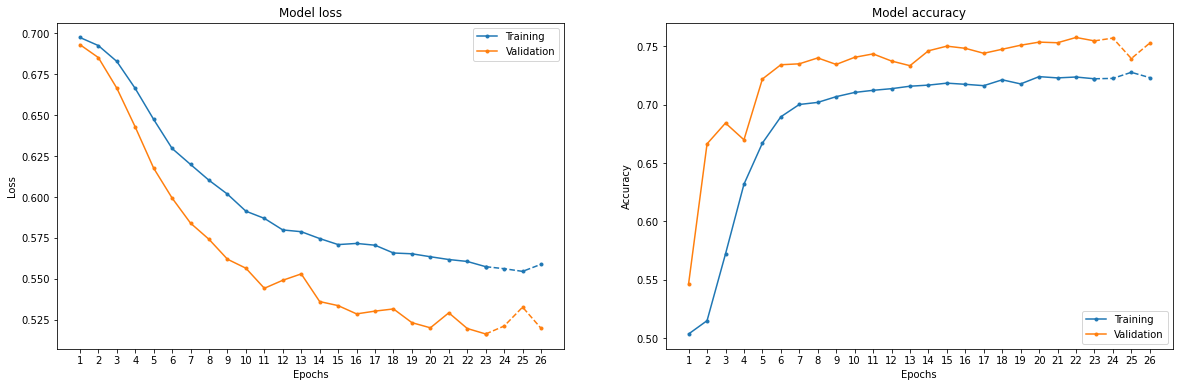

In [ ]:
resume_model_history(history_mn_tune, early_stop)

In [ ]:
# salvataggio del modello
model_mn_tune.save(drive_path + 'Keras_Model/mobnet_tuning.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Verificando i risultati sul test set è possibile notare come le metriche siano sostanzialmente invariate rispetto all'architettura iniziale. Cosi come il tempo necessario per le predizioni.


Classification Report
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      2500
           1       0.76      0.71      0.73      2500

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



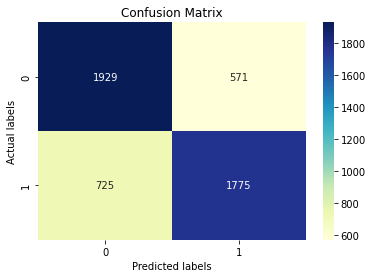

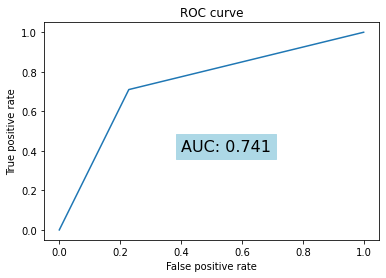

In [ ]:
# model_mn_tune = keras.models.load_model(drive_path + 'Keras_Model/mobnet_tuning.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_mn_tune, test_set, label_test['label'].values)

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = model_mn_tune.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.157 secondi necessari per predire una singola immagine! ---


### DenseNet-121 tuning
Effettuiamo il tuning su densenet, oltre agli stessi parametri tunati su mobilenet viene inserito un nuovo parametro per decidere se inserire o meno un nuovo layer fully connected finale, e nel caso con quanti neuroni.

Come prima è necessario definire la funzione di creazione del modello con gli iperparametri.

In [ ]:
def dn_model_builder(hp):
  # definisco la sequenza di operazioni del macro modello
  inputs = keras.Input(shape=train_set.image_shape) # layer di input
  x = inputs

  hp_flip = hp.Boolean('random_flip', default=False)
  if hp_flip:
    # flip dell'immagine
    x = keras.layers.RandomFlip(mode = "horizontal_and_vertical")(x)

  # rotazione dell'immagine
  hp_rotation = hp.Float('random_rotation', min_value=0.0, max_value=0.5, step=0.05, default=0.0)
  x = keras.layers.RandomRotation(factor =  hp_rotation)(x)

  # contrasto randomico
  hp_contrast = hp.Float('random_constrast', min_value=0.0, max_value=0.7, step=0.1, default=0.0)
  if hp_contrast != 0:
    x = keras.layers.RandomContrast(factor = hp_contrast)(x)

  # applico lo stesso preprocessing applicato all'input di densenet
  x = keras.applications.densenet.preprocess_input(x)
  # applico la rete densenet-121 precedentemente estratta
  x = dn121_model(x)

  # LAYER AGGIUNTIVI
  initializer = keras.initializers.GlorotUniform(seed=1234)

  # Tune del numero di neuroni per i layer densi
  hp_dense = hp.Int('dense_0', min_value=32, max_value=128, step=32, default = 64)
  x = keras.layers.Dense(hp_dense, activation = "relu", kernel_initializer=initializer)(x)
  hp_drop = hp.Choice('dropout_0', values=[0.0, 0.2, 0.4, 0.5], default = 0.0)
  x = keras.layers.Dropout(hp_drop)(x)
  hp_dense1 = hp.Int('dense_1', min_value=16, max_value=32, step=16, default = 32)
  x = keras.layers.Dense(hp_dense1, activation = "relu", kernel_initializer=initializer)(x)
  hp_drop1 = hp.Choice('dropout_1', values=[0.0, 0.2, 0.4, 0.5], default = 0.4)
  x = keras.layers.Dropout(hp_drop1)(x)
  hp_dense2 = hp.Int('dense_2', min_value=8, max_value=16, step=8, default = 8)
  x = keras.layers.Dense(hp_dense2, activation = "relu", kernel_initializer=initializer)(x)

  hp_dense3 = hp.Int('dense_3', min_value=0, max_value=16, step=8, default = 0)
  if hp_dense3 != 0:
    x = keras.layers.Dense(hp_dense3, activation = "relu", kernel_initializer=initializer)(x)

  # layer che mappa al numero di classi del nostro problema
  x = keras.layers.Dense(2, activation = "sigmoid")(x)

  outputs = x

  # definisco il macro modello
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Tune learning rate per l'ottimizzatore
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss="binary_crossentropy", 
                metrics = ["accuracy", Recall(name = 'recall')])

  return model

Dato che le combinazioni per il tuning sono molte si utilizza l'ottimizzatore bayesiano che permette di non testare tutte le possibili casistiche. Ogni nuova combinazione di iperparametri è infatti definita a partire dalle iterazioni precedenti basandosi sulle probabilità

In [ ]:
tuner = kt.BayesianOptimization(dn_model_builder,
                                objective='val_accuracy',
                                directory=drive_path+'keras_tuner',
                                max_trials = 100, overwrite=False,
                                project_name='densenet_opt')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/densenet_opt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/densenet_opt/tuner0.json


Faccio partire il tuner sul modello con un numero massimo di $25$ epoche, verrà inoltre utilizzata la stessa tecnica di earlyStopping descritta in precedenza.

In [ ]:
tuner.search(train_set, epochs=25, validation_data = validation_set,
             shuffle = True, callbacks=[early_stop])

La nuova architettura è molto diversa dalla precedente. Possiamo notare come siano stati rimossi entrambi i dropout, inoltre i layer di data augmentation sono stati tutti inutilizzati. Infine possiamo notare che anche il nuovo possibile layer fully connected è stato scartato.

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print('------ Migliori parametri DenseNet: ------')
best_hps.values

------ Migliori parametri DenseNet: ------


{'dense_0': 128,
 'dense_1': 16,
 'dense_2': 16,
 'dense_3': 0,
 'dropout_0': 0.0,
 'dropout_1': 0.0,
 'learning_rate': 0.01,
 'random_constrast': 0.0,
 'random_flip': False,
 'random_rotation': 0.0}

Il tuner restituisce un modello già allenato sui parametri migliori, tuttavia è bene rieseguire il training da zero costruendo un nuovo modello. Nel farlo aumentiamo il numero di epoche tornando alla configurazione iniziale di $50$.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_dn_tune = tuner.hypermodel.build(best_hps)
history_dn_tune = model_dn_tune.fit(train_set, epochs=50, shuffle = True, 
                                    validation_data = validation_set, 
                                    callbacks=[early_stop])

Epoch 1/50
334/334 [==============================] - 86s 232ms/step - loss: 0.5721 - accuracy: 0.6975 - recall: 0.6932 - val_loss: 0.5272 - val_accuracy: 0.7411 - val_recall: 0.7414
Epoch 2/50
334/334 [==============================] - 74s 221ms/step - loss: 0.5242 - accuracy: 0.7406 - recall: 0.7403 - val_loss: 0.5132 - val_accuracy: 0.7541 - val_recall: 0.7525
Epoch 3/50
334/334 [==============================] - 76s 227ms/step - loss: 0.5211 - accuracy: 0.7446 - recall: 0.7445 - val_loss: 0.5174 - val_accuracy: 0.7432 - val_recall: 0.7459
Epoch 4/50
334/334 [==============================] - 77s 231ms/step - loss: 0.5167 - accuracy: 0.7460 - recall: 0.7465 - val_loss: 0.4956 - val_accuracy: 0.7634 - val_recall: 0.7610
Epoch 5/50
334/334 [==============================] - 77s 230ms/step - loss: 0.5126 - accuracy: 0.7531 - recall: 0.7541 - val_loss: 0.5215 - val_accuracy: 0.7515 - val_recall: 0.7594
Epoch 6/50
334/334 [==============================] - 76s 227ms/step - loss: 0.5033 -

I risultati sono nuovamente simili alla rete base di partenza, tuttavia migliora leggermente l'andamento dell'underfitting anche se ancora presente.

Numero di epoche totali: 18
Epoca migliore (weights restored): 15
Accuracy training set all'epoca 15: 0.7741254568099976
Accuracy validation set all'epoca 15: 0.787347137928009
Loss training set all'epoca 15: 0.47911015152931213
Loss validation set all'epoca 15: 0.45002344250679016





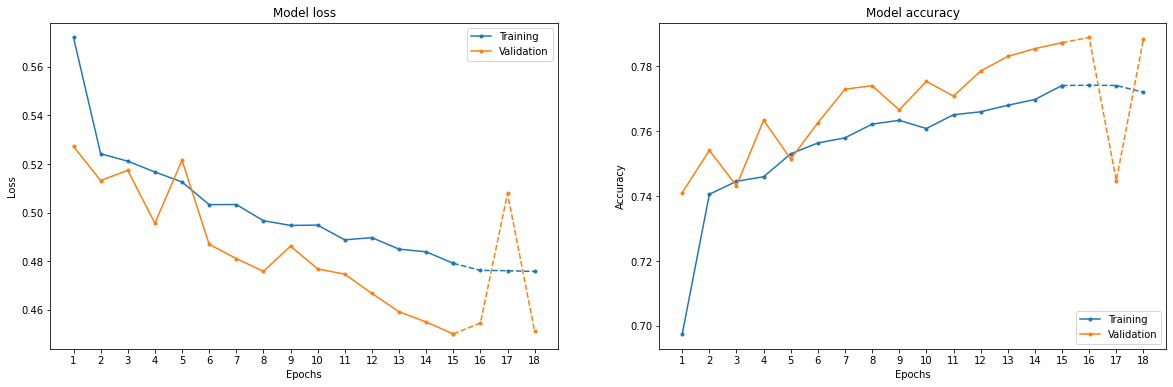

In [ ]:
resume_model_history(history_dn_tune, early_stop)

In [ ]:
# salvataggio del modello
model_dn_tune.save(drive_path + 'Keras_Model/densenet_tuning.h5')

Verificando i risultati sul test set è possibile notare come le metriche siano sostanzialmente invariate rispetto all'architettura iniziale. Cosi come il tempo necessario per le predizioni.


Classification Report
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      2500
           1       0.78      0.79      0.78      2500

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



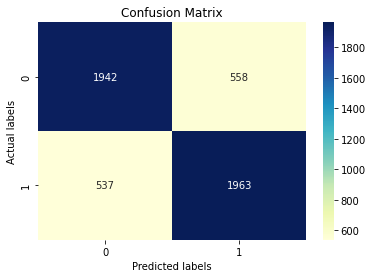

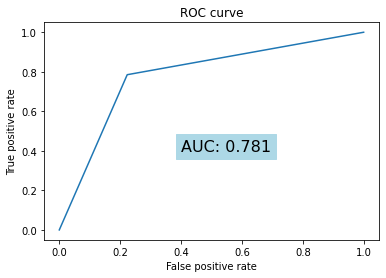

In [ ]:
# model_dn_tune = keras.models.load_model(drive_path + 'Keras_Model/densenet_tuning.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_dn_tune, test_set, label_test['label'].values)

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = model_dn_tune.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.218 secondi necessari per predire una singola immagine! ---


### VGG16 tuning
Effettuiamo il tuning su vgg-16, utilizzando gli stessi parametri di base di mobilenet.


Anche in questo caso come prima cosa definiamo la funzione per la creazione del modello con gli iperparametri da tunare.


In [ ]:
def vgg_model_builder(hp):
  # definisco la sequenza di operazioni del macro modello
  inputs = keras.Input(shape=train_set.image_shape) # layer di input
  x = inputs

  hp_flip = hp.Boolean('random_flip', default=False)
  if hp_flip:
    # flip dell'immagine
    x = keras.layers.RandomFlip(mode = "horizontal_and_vertical")(x)

  # rotazione dell'immagine
  hp_rotation = hp.Float('random_rotation', min_value=0.0, max_value=0.5, step=0.05)
  x = keras.layers.RandomRotation(factor =  hp_rotation)(x)

  # contrasto randomico
  hp_contrast = hp.Float('random_constrast', min_value=0.0, max_value=0.7, step=0.1)
  if hp_contrast != 0:
    x = keras.layers.RandomContrast(factor = hp_contrast)(x)

  # applico lo stesso preprocessing applicato all'input di vgg16
  x = keras.applications.vgg16.preprocess_input(x)
  # applico la rete VGG16 precedentemente estratta
  x = vgg16_model(x)

  # LAYER AGGIUNTIVI
  initializer = keras.initializers.GlorotUniform(seed=4568)

  # Tune del numero di neuroni per i layer densi
  hp_dense = hp.Int('dense_0', min_value=32, max_value=128, step=32)
  x = keras.layers.Dense(hp_dense, activation = "relu", kernel_initializer=initializer)(x)
  hp_drop = hp.Choice('dropout_0', values=[0.0, 0.2, 0.4, 0.5])
  x = keras.layers.Dropout(hp_drop)(x)
  hp_dense1 = hp.Int('dense_1', min_value=16, max_value=32, step=16)
  x = keras.layers.Dense(hp_dense1, activation = "relu", kernel_initializer=initializer)(x)
  hp_drop1 = hp.Choice('dropout_1', values=[0.0, 0.2, 0.4, 0.5])
  x = keras.layers.Dropout(hp_drop1)(x)
  hp_dense2 = hp.Int('dense_2', min_value=8, max_value=16, step=8)
  x = keras.layers.Dense(hp_dense2, activation = "relu", kernel_initializer=initializer)(x)
  # layer che mappa al numero di classi del nostro problema
  x = keras.layers.Dense(2, activation = "sigmoid")(x)

  outputs = x

  # definisco il macro modello
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Tune learning rate per l'ottimizzatore
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss="binary_crossentropy", 
                metrics = ["accuracy", Recall(name = 'recall')])

  return model

Dato che le combinazioni per il tuning sono molte si utilizza l'ottimizzatore bayesiano che permette di non testare tutte le possibili casistiche. Ogni nuova combinazione di iperparametri è infatti definita a partire dalle iterazioni precedenti basandosi sulle probabilità

In [ ]:
tuner = kt.BayesianOptimization(vgg_model_builder,
                                objective='val_accuracy',
                                directory=drive_path+'keras_tuner',
                                max_trials = 100, overwrite=False,
                                project_name='vgg_opt')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/vgg_opt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/AML/Progetto/keras_tuner/vgg_opt/tuner0.json


Faccio partire il tuner sul modello con un numero massimo di $25$ epoche, verrà inoltre utilizzata la stessa tecnica di earlyStopping descritta in precedenza.

In [ ]:
tuner.search(train_set, epochs=25, validation_data = validation_set,
             shuffle = True, callbacks=[early_stop])

in questo caso l'architettura è molto più simile a quella base individuata, tuttavia vengono nuovamente eliminati i layer di dropout. Mentre viene mantenuto il layer di random rotation con un fattore pari a $0.5$.

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print('------ Migliori parametri VGG-16: ------')
best_hps.values

------ Migliori parametri VGG-16: ------


{'dense_0': 32,
 'dense_1': 32,
 'dense_2': 8,
 'dropout_0': 0.0,
 'dropout_1': 0.0,
 'learning_rate': 0.0001,
 'random_constrast': 0.0,
 'random_flip': False,
 'random_rotation': 0.5}

Il tuner restituisce un modello già allenato sui parametri migliori, tuttavia è bene rieseguire il training da zero costruendo un nuovo modello. Nel farlo aumentiamo il numero di epoche tornando alla configurazione iniziale di $50$.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_vgg_tune = tuner.hypermodel.build(best_hps)
history_vgg_tune = model_vgg_tune.fit(train_set, epochs=50, shuffle = True, 
                                      validation_data = validation_set, 
                                      callbacks=[early_stop])

Epoch 1/50
334/334 [==============================] - 117s 320ms/step - loss: 0.6776 - accuracy: 0.5979 - recall: 0.4458 - val_loss: 0.6699 - val_accuracy: 0.6414 - val_recall: 0.6047
Epoch 2/50
334/334 [==============================] - 99s 295ms/step - loss: 0.6596 - accuracy: 0.6760 - recall: 0.7310 - val_loss: 0.6491 - val_accuracy: 0.6903 - val_recall: 0.7440
Epoch 3/50
334/334 [==============================] - 99s 296ms/step - loss: 0.6507 - accuracy: 0.6892 - recall: 0.7171 - val_loss: 0.6411 - val_accuracy: 0.6932 - val_recall: 0.7180
Epoch 4/50
334/334 [==============================] - 99s 297ms/step - loss: 0.6440 - accuracy: 0.6928 - recall: 0.7089 - val_loss: 0.6361 - val_accuracy: 0.7071 - val_recall: 0.7103
Epoch 5/50
334/334 [==============================] - 99s 297ms/step - loss: 0.6350 - accuracy: 0.7011 - recall: 0.7114 - val_loss: 0.6239 - val_accuracy: 0.7158 - val_recall: 0.7217
Epoch 6/50
334/334 [==============================] - 100s 298ms/step - loss: 0.6281

Dal nuovo addestramento della rete è possibile notare come l'andamento sia migliore con un underfitting meno pronunciato. Tuttavia i risultati sul validation rimangono pressochè invariati, inoltre aumentano di molto le epoche richieste per il training.

Numero di epoche totali: 42
Epoca migliore (weights restored): 39
Accuracy training set all'epoca 39: 0.7347369194030762
Accuracy validation set all'epoca 39: 0.7424242496490479
Loss training set all'epoca 39: 0.5450108647346497
Loss validation set all'epoca 39: 0.5299468636512756





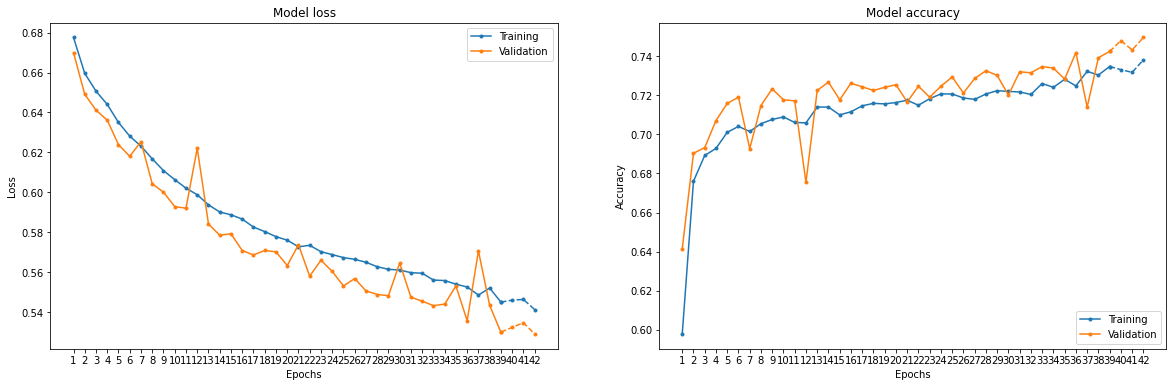

In [ ]:
resume_model_history(history_vgg_tune, early_stop)

In [ ]:
# salvataggio del modello
model_vgg_tune.save(drive_path + 'Keras_Model/vgg16_tuning.h5')

I risultati del test set confermano che, anche per VGG, non vi è alcun miglioramento delle performance dopo l'ottimizzazione.


Classification Report
               precision    recall  f1-score   support

           0       0.78      0.68      0.73      2500
           1       0.72      0.81      0.76      2500

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.74      5000
weighted avg       0.75      0.75      0.74      5000



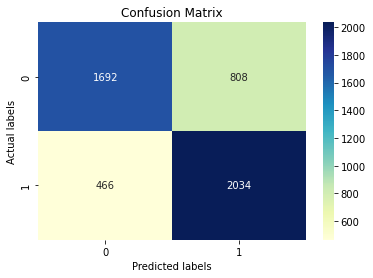

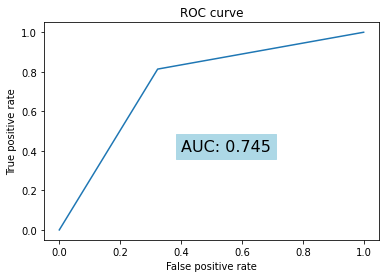

In [ ]:
# model_vgg_tune = keras.models.load_model(drive_path + 'Keras_Model/vgg16_tuning.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_vgg_tune, test_set, label_test['label'].values)

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = model_vgg_tune.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.193 secondi necessari per predire una singola immagine! ---


### Ensemble tuning
Si prova a sviluppare la tecnica di average ensemble utilizzando i tre modelli tunati, come fatto per i modelli base.

In [ ]:
# Carico i modelli già trainati
model_mn = keras.models.load_model(drive_path + 'Keras_Model/mobnet_tuning.h5', compile=False)
model_mn._name = 'model1'
model_dn = keras.models.load_model(drive_path + 'Keras_Model/densenet_tuning.h5', compile=False)
model_dn._name = 'model2'
model_vgg = keras.models.load_model(drive_path + 'Keras_Model/vgg16_tuning.h5', compile=False)
model_vgg._name = 'model3'

# definisco la lista con i 3 modelli
models = [model_mn, model_dn, model_vgg]
# setto il layer di input
model_input = keras.Input(shape=train_set.image_shape)
# utilizzo i tre modelli per effettuate le predizioni e medio i valori del risultato
model_outputs = [model(model_input) for model in models]
ensemble_output = keras.layers.Average()(model_outputs)
ensemble_model = keras.Model(inputs=model_input, outputs=ensemble_output)  

# salvo l'ensemble
ensemble_model.save(drive_path + 'Keras_Model/ensemble_tuning.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Anche per l'ensemble non si notano particolari differenze rispetto al caso base, come ci si attendeva visto che non vi sono differenze nei singoli modelli.


Classification Report
               precision    recall  f1-score   support

           0       0.78      0.75      0.76      2500
           1       0.76      0.78      0.77      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



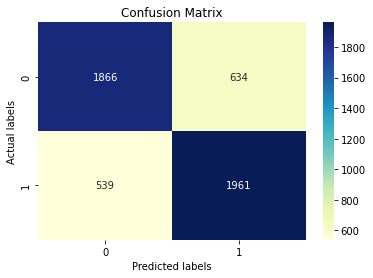

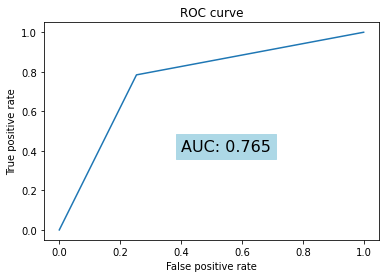

In [ ]:
# ensemble_model = keras.models.load_model(drive_path + 'Keras_Model/ensemble_tuning.h5', compile=False)
# valuto l'ensemble sul test set
_, _ = evaluate_prediction(ensemble_model, test_set, label_test['label'].values)

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set.batch_size):
  _ = ensemble_model.predict(test_set[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set.batch_size, 3))

--- 0.311 secondi necessari per predire una singola immagine! ---


## Medium training set
Finora i modelli sono stati trainati considerando una sottoporzione piccola, rispetto a tutto il dataset a dispozione, quindi in questa sezione verrà trainato il modello migliore individuato fin qui: (*densenet*) utilizzando una versione più grande del dataset di training. Tuttavia non ci aspettiamo un miglioramento in quanto la sua top-$1$ accuracy dipende dai layer pre-trainati i cui pesi rimangono freezzati.

### Data Loader -medium-
Procediamo a scaricare da drive i nuovi dataset e ad estrarre lo zip in locale su colab cosi da poter utilizzare i nuovi dataset. Le funzioni di loading rimangono invariate rispetto a prima e non richiedono modifiche specifiche.

In [ ]:
# carico il dataset medium sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/train_medium.zip', 'train_medium.zip')
zip = zipfile.ZipFile('train_medium.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('train_medium.zip')

In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'Data/test_medium.zip', 'test_medium.zip')
zip = zipfile.ZipFile('test_medium.zip')
zip.extractall()
zip.close()
# cancello dalla root lo zip
os.remove('test_medium.zip')

# copio anche il csv che contiene le label di riferimento per il test set
shutil.copyfile(drive_path + 'Data/dataset_labels/test_medium_label.csv', 'test_medium_label.csv')

'test_medium_label.csv'

Importo il training e test set con i metodi predisposti all'inizio del notebook.

In [ ]:
print('Training set:')
# carico le nuove immagini di training, per farlo passo il path specifico della cartella
train_set_med, validation_set_med = import_train_validation(img_size = (224,224), 
                                                            val_split = 0.15, 
                                                            batch_size =  64, 
                                                            dataset_path = './train_medium')

print('\n\nTest set:')
# carico il test set unico per tutti i modelli per poterli valutare coerentemente
test_set_med, label_test_med = import_test(img_size = (224,224), 
                                           batch_size =  64,
                                           dataset_path = './test_medium')

Training set:
Found 85300 images belonging to 2 classes.
Found 15052 images belonging to 2 classes.


Test set:
Found 18000 images belonging to 1 classes.


Si può notare come in questo caso si hanno a disposizione $85300$ immagini di solo training (escluso validation) contro le $21326$ presenti nel dataset più piccolo. E anche per il test set si hanno a disposizione $18000$ immagini contro le $5000$ del test set small.

### Densenet on medium dataset
Utilizzo lo stesso modello denseNet-$121$ definito in precedenza e lo addestro questa volta col nuovo dataset. Per essere sicuro che il modello riparta l'addestramento da zero lo ridefinisco. 

Il modello viene ridefinito da zero per assicurarsi che i pesi siano nuovamente azzerati ed evitare problemi di sorta. L'architettura resta comunque invariata.

In [ ]:
# voglio che tutti i layer già presenti non siano nuovamente trainati cosi mantengo i pesi
for layer in dn121_model.layers:
  layer.trainable = False


# definisco la sequenza di operazioni del macro modello
inputs = keras.Input(shape=train_set_med.image_shape) # layer di input
x = inputs

# applico lo stesso preprocessing applicato all'input di densenet
x = keras.applications.densenet.preprocess_input(x)
# applico la rete densenet-121 precedentemente estratta
x = dn121_model(x)

# LAYER AGGIUNTIVI

initializer = keras.initializers.GlorotUniform(seed=1234)

# fully connected che mappa a 64
x = keras.layers.Dense(64, activation = "relu", kernel_initializer=initializer)(x)
#x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, activation = "relu", kernel_initializer=initializer)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation = "relu", kernel_initializer=initializer)(x)
# layer che mappa al numero di classi del nostro problema
x = keras.layers.Dense(2, activation = "sigmoid")(x)

outputs = x

In [ ]:
# definisco il macro modello
model_dn_med = keras.Model(inputs=inputs, outputs=outputs)

model_dn_med.compile(optimizer=keras.optimizers.Adam(0.001), 
                     loss="binary_crossentropy", 
                     metrics=["accuracy", Recall(name = 'recall')])

Addestriamo il modello con più dati, in questo caso aumentiamo il numero di epoche a $150$ per assicurarci che siano abbastanza per il training. Infine verrà usata la medesima tecnica di early_stopping.

In [ ]:
model_dn_med_hist = model_dn_med.fit(train_set_med, epochs = 150, shuffle = True,
                                     validation_data = validation_set_med,
                                     verbose = 1, callbacks = [early_stop])

Epoch 1/150
1333/1333 [==============================] - 623s 462ms/step - loss: 0.5388 - accuracy: 0.7362 - recall: 0.7332 - val_loss: 0.4920 - val_accuracy: 0.7633 - val_recall: 0.7685
Epoch 2/150
1333/1333 [==============================] - 608s 456ms/step - loss: 0.5068 - accuracy: 0.7572 - recall: 0.7611 - val_loss: 0.4794 - val_accuracy: 0.7729 - val_recall: 0.7688
Epoch 3/150
1333/1333 [==============================] - 609s 457ms/step - loss: 0.4959 - accuracy: 0.7658 - recall: 0.7730 - val_loss: 0.4689 - val_accuracy: 0.7786 - val_recall: 0.7802
Epoch 4/150
1333/1333 [==============================] - 610s 457ms/step - loss: 0.4846 - accuracy: 0.7709 - recall: 0.7812 - val_loss: 0.4621 - val_accuracy: 0.7868 - val_recall: 0.8032
Epoch 5/150
1333/1333 [==============================] - 608s 456ms/step - loss: 0.4772 - accuracy: 0.7749 - recall: 0.7868 - val_loss: 0.4512 - val_accuracy: 0.7892 - val_recall: 0.7945
Epoch 6/150
1333/1333 [==============================] - 609s 457

Il modello non mostra alcuna differenza rispetto a quello trainato sul dataset small, sia dal punto di vista delle performance sia dal punto di vista dell'underfitting. Quest'ultimo problema ci attendavamo si attenuasse in quanto il modello ha più dati su cui addestrarsi.

Numero di epoche totali: 16
Epoca migliore (weights restored): 13
Accuracy training set all'epoca 13: 0.7910434007644653
Accuracy validation set all'epoca 13: 0.8002258539199829
Loss training set all'epoca 13: 0.45016610622406006
Loss validation set all'epoca 13: 0.4322252869606018





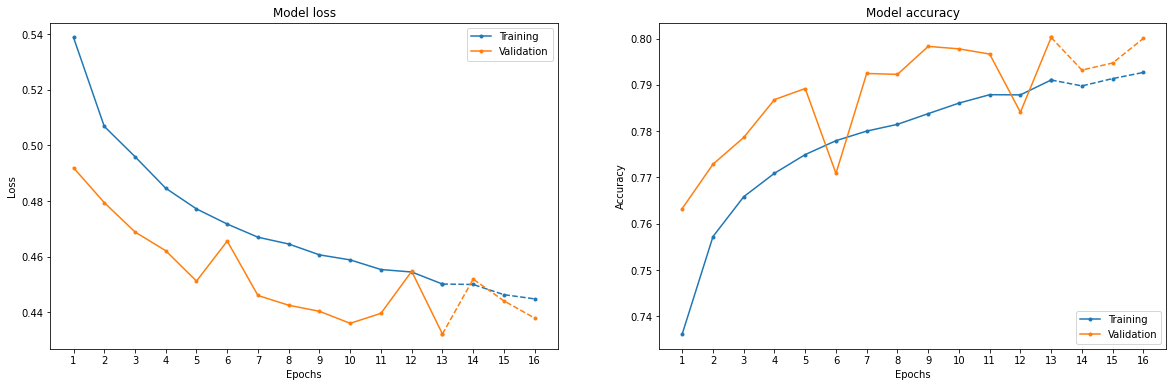

In [ ]:
resume_model_history(model_dn_med_hist, early_stop)

In [ ]:
# salvataggio del modello
model_dn_med.save(drive_path + 'Keras_Model/densenet_med.h5')

Analizzando le performance sul test set medium non si notano differenze rispetto al caso base. Inoltre anche il tempo per la predizione è invariato.


Classification Report
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      9000
           1       0.81      0.77      0.79      9000

    accuracy                           0.79     18000
   macro avg       0.79      0.79      0.79     18000
weighted avg       0.79      0.79      0.79     18000



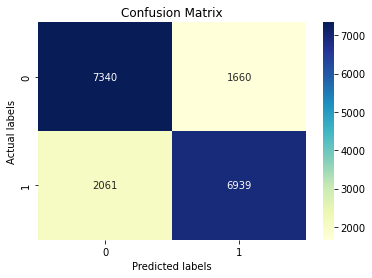

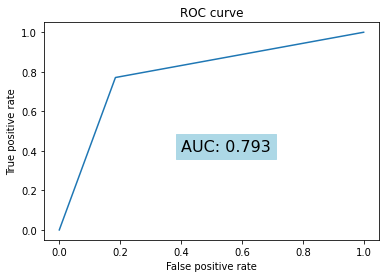

In [ ]:
# model_dn_med = keras.models.load_model(drive_path + 'Keras_Model/densenet_med.h5', compile=False)
# valuto il modello sul test set
_, _ = evaluate_prediction(model_dn_med, test_set_med, label_test_med['label'].values)

In [ ]:
# PER AVERE UN TEMPO REALE E' MEGLIO FAR RIPARTIRE IL NOTEBOOK ED ESEGUIRE SOLTANTO QUESTA CELLA
# ALTRIMENTI ALCUNE PREDIZIONI POTREBBERO ESSERE IN MEMORIA
start_time = time.time()

# effettuo le predizioni su un batch
for i in range(test_set_med.batch_size):
  _ = model_dn_med.predict(test_set_med[0][0][i].reshape(1,224,224,3))

# visualizzo il tempo medio per la predizione di ogni img
print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set_med.batch_size, 3))

--- 0.218 secondi necessari per predire una singola immagine! ---


Date queste prove non sembrano esserci differenze nel fine-tuning se si utilizza un dataset più piccolo o più grande, questo ovviamente per questo particolare task. Ciò ci porta a pensare che i modelli siano pre-addestrati su task abbastanza validi che permettono di raggiungere accuracy buone, tuttavia i task di imagenet non sono così specifici da permettere performance ottimali.

## Predizione sul test set kaggle
In questa sezione verrà utilizzato il modello migliore trovato, ovvero la rete denseNet-121 addestrata sul dataset medio, per predire le immagini presenti nel test set di kaggle. Cosi facendo è possibile caricare le predizioni sulla challenge e ricevere una verifica dei risultati confrondandoci così con gli altri.

In [ ]:
# carico il file zip contenente le immagini da Drive
shutil.copyfile(drive_path + 'Data/test_kaggle.zip', 'test_kaggle.zip')
zip = zipfile.ZipFile('test_kaggle.zip')
zip.extractall('./test_kaggle')
zip.close()
# cancello dalla root lo zip
os.remove('test_kaggle.zip')

Carico il nuovo dataset, per farlo definisco un nuovo loader locale in quanto la struttura della cartella è diversa da quella utilizzata finora. I dati infatti non sono inseriti in un ulteriore sottocartella.

In [ ]:
# carico il dataset di kaggle dalla cartella
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# carico il test set
test_kaggle = image_generator.flow_from_directory(
    './test_kaggle',
    color_mode = 'rgb',
    class_mode = None,
    classes=[''], # classe fittizzia
    shuffle = False,
    target_size = (96,96),
    batch_size = 64
)

Found 57458 images belonging to 1 classes.


Si hanno a disposizione circa $57458$ immagini su cui effettuare la predizione. I risultati ci attendiamo siano simili a quelli ottenuti sul test set medium.

In [ ]:
# carico il modello pre-trainato
model_kaggle = keras.models.load_model(drive_path + 'Keras_Model/densenet.h5', compile=False)

In [ ]:
# utilizzo il modello sul test set di kaggle ed estraggo le predizioni
y_pred_kaggle = model_kaggle.predict(test_kaggle)
# estraggo la label corrispondente come valore binario
y_pred_kaggle = y_pred_kaggle.argmax(axis=1)

Creo il file per le previsioni come da specifiche kaggle.

In [ ]:
# creo un dataframe per la submission contenente nome file, previsione
submission = pd.DataFrame(columns = ['id', 'label'])
# estraggo i nomi del file senza estensione .tif
lst_temp = [os.path.splitext(x)[0] for x in test_kaggle.filenames]
submission['id'] = lst_temp # colonna col nome del file
submission['label'] = y_pred_kaggle # colonna con le previsioni

Salvo il file csv per poterlo caricare su kaggle.

In [ ]:
# scarico il file csv con le predizioni
submission.to_csv('kaggle_sub.csv', header = True, index = False)